# Session 2

<p>
In this exercise, we're going to build a small preprocessing workflow that prepares traces and then computes the cross correlation from the results.
</p>

In [1]:
from obspy.core import read
sta1 = 'A25A.TA..BHZ.2011.025.00.00.00.000-2011.026.00.00.39.000.rm.scale-AUTO.SAC'
sta2 = 'BMN.LB..BHZ.2011.025.00.00.00.023-2011.026.00.00.38.998.rm.scale-AUTO.SAC'

The first two functions are similar to the ones in the previous session. The first one (stream_producer) reads a file that contains seismological traces and returns it as an obspy stream. The second one (readstats) extracts the station's start time, the station's name of the first trace and returns a stream with three values: station's starttime, station's name and the obspy stream. The reason for returning those values is that later we are going to group the data by station's start time for computing the cross correlation.

In [2]:
from dispel4py.base import SimpleFunctionPE, IterativePE, create_iterative_chain

def stream_producer(data):
    filename = data
    st = read(filename)
    return st

def readstats(st):
    station_date = st[0].stats['starttime'].date
    station_day = station_date.strftime('%d-%m-%Y')
    station = st[0].stats['station']
    return [station_day, station, st]

### Functions to preprocess the trace data

This is the 'preprocess pipeline' which is a composite PE for processing several functions (decimate, detrend, demean and filter) in a sequence.

In [3]:
def decimate(st, sps):
    st.decimate(int(st[0].stats.sampling_rate/sps))
    return st

def detrend(st):
    st.detrend('simple')
    return st

def demean(st):
    st.detrend('demean')
    return st

def filter(st, freqmin=0.01, freqmax=1., corners=4, zerophase=False):
    st.filter('bandpass', freqmin=freqmin, freqmax=freqmax, corners=corners, zerophase=zerophase)
    return st

This is the 'preprocess pipeline' which is a composite PE for processing several functions (decimate, detren and deman) in a sequence.

You can create a pipeline of processing elements that run a list of functions, for example, this creates a chain with the functions decimate and detrend. Note that decimate has one parameter 'sps' with value 4.

In [6]:
preprocess_trace = create_iterative_chain([ (decimate, {'sps':4}) ])

This creates a composite PE which you can also visualise as a graph.

In [7]:
from dispel4py.visualisation import display
display(preprocess_trace)

Now we create another function for whitening obspy stream.

In [14]:
from numpy import arange, sqrt, abs, multiply, conjugate, real
from obspy.signal.util import next_pow_2
from scipy.fftpack import fft, ifft

def spectralwhitening(st):
    """
    Apply spectral whitening to data.
    Data is divided by its smoothed (Default: None) amplitude spectrum.
    """
    
    for trace in arange(len(st)):
        data = st[trace].data
        
        n = len(data)
        nfft = next_pow_2(n)
        
        spec = fft(data, nfft)
        spec_ampl = sqrt(abs(multiply(spec, conjugate(spec))))
        
        spec /= spec_ampl  #Do we need to do some smoothing here?
        ret = real(ifft(spec, nfft)[:n])
        
        st[trace].data = ret
        
    return st

<h2>Exercise 1</h2>
<p> 
Create your own function to preprocess the data. Later it could be added to the CompositePE. 
</p>

In [22]:
def taper(data):
    data.taper(10.0)
    return data

<h2>Exercise 2</h2>
<p> 
Now it's time to create the graph for preprocessing the traces. 

An example of the filter parameter that can be used is :
'freqmin':0.01, 'freqmax':1., 'corners':4, 'zerophase':False. 

Remenber that the worfklow first has to read the file that contains the traces, then preprocess them (composite PE), and finally extract the station's start time,  the station's name and stream. You can chose how many functions want to add to the create_iterative_chain for preprocess the traces.  
</p>


In [24]:
from dispel4py.workflow_graph import WorkflowGraph
streamProducer = SimpleFunctionPE(stream_producer) 
streamProducer.name = "streamProducer"
preprocess_trace = create_iterative_chain([ (decimate, {'sps': 4}), detrend, demean, spectralwhitening,taper ])
sta = SimpleFunctionPE(readstats)

graph = WorkflowGraph()
graph.connect(streamProducer, 'output', preprocess_trace,'input')
graph.connect(preprocess_trace, 'output', sta,'input')

**Optional:** Visualise the workflow graph.

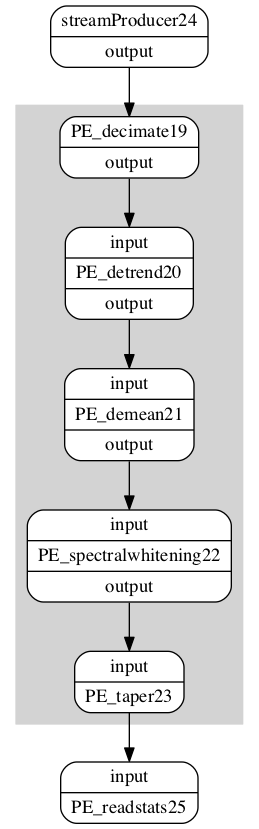

In [25]:
display(graph)

<h2>Exercise 3</h2> 
<p>
Finally execute the graph and preprocess the traces from two different stations. 
</p>


In [26]:
#from dispel4py import simple_process
from dispel4py.new.simple_process import process as simple_process
input_data = { streamProducer : [ {'input' : sta1 }, {'input' : sta2 }] }
graph.flatten()
#simple_process.process(graph, input_data)
simple_process(graph, input_data)

Inputs: {'streamProducer24': [{'input': 'http://escience8.inf.ed.ac.uk:8080/laquila/SAC/A25A.TA..BHZ.2011.025.00.00.00.000-2011.026.00.00.39.000.rm.scale-AUTO.SAC'}, {'input': 'http://escience8.inf.ed.ac.uk:8080/laquila/SAC/BMN.LB..BHZ.2011.025.00.00.00.023-2011.026.00.00.38.998.rm.scale-AUTO.SAC'}]}
SimplePE: Processed 1 iteration.
Outputs: {'PE_readstats25': {'output': [['25-01-2011', u'A25A', <obspy.core.stream.Stream object at 0x1039c7090>], ['25-01-2011', u'BMN', <obspy.core.stream.Stream object at 0x1090d4290>]]}}


//anaconda/lib/python2.7/site-packages/obspy/core/trace.py:1928: UserWarning: The requested taper is longer than the trace. The taper will be shortened to trace length.
  warnings.warn(msg)


<h3>Note:</h3> 
<p>
For executing with another mappings, copy all the lines ( execept the last 3) into a script ( session2.py): <br/>
<ul>
<li > Multiprocessing mapping for shared memory machine (several cores in the same cpu):<br/>

<tt> dispel4py multi session2 -n 4 <br/>
    -d "{ \"StreamProducer\" : [ { \"input\" : \"http://escience8.inf.ed.ac.uk:8080/laquila/SAC/A25A.TA..BHZ.2011.025.00.00.00.000-2011.026.00.00.39.000.rm.scale-AUTO.SAC\" }, { \"input\" : \"http://escience8.inf.ed.ac.uk:8080/laquila/SAC/BMN.LB..BHZ.2011.025.00.00.00.023-2011.026.00.00.38.998.rm.scale-AUTO.SAC\"} ] }"</tt></li> 


    <li > MPI mapping for distributed memory machine (several cores in several cpus):<br/>

<tt> mpiexec -n 4 dispel4py mpi session2  <br/>
    -d "{ \"StreamProducer\" : [ { \"input\" : \"http://escience8.inf.ed.ac.uk:8080/laquila/SAC/A25A.TA..BHZ.2011.025.00.00.00.000-2011.026.00.00.39.000.rm.scale-AUTO.SAC\" }, { \"input\" : \"http://escience8.inf.ed.ac.uk:8080/laquila/SAC/BMN.LB..BHZ.2011.025.00.00.00.023-2011.026.00.00.38.998.rm.scale-AUTO.SAC\"} ] }"</tt></li> 
</ul>
</p>

<h2>Exercise 4</h2> 
<p>
Convert 'decimate' function into a IterativePE called DecimatePE. </p>
<p>Modify the graph, for using the DecimatePE:</p>
<ul>
    <li> modify the compositePE (preprocess_trace) to remove decimate function from the creative_iterative_chain </li>
    <li> create the decimatePE object </li>
    <li>  connect streamProducer to decimantePE </li>
    <li>  connect decimatePE to preprocess_trace </li>
    <li>  ... </li>

</ul>


In [ ]:
class DecimatePE(IterativePE):

    def __init__(self, sps):
        IterativePE.__init__(self)
        self.sps = sps

    def _process(self, data):
        st = data
        st.decimate(int(st[0].stats.sampling_rate/self.sps))
        return st


decimate = DecimatePE(4)
preprocess_trace = create_iterative_chain([ ... ])
streamProducer = ...

graph = WorkflowGraph()
graph.connect(streamProducer, 'output', decimate, 'input')
graph.connect(decimate, 'output', preprocess_trace, 'input')